In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from keras.layers import Activation, Dense
import gc
from keras.models import Sequential
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,RocCurveDisplay,ConfusionMatrixDisplay,confusion_matrix,roc_auc_score,accuracy_score
from catboost import CatBoostClassifier
from IPython.display import clear_output
from sklearn import model_selection

from bayes_opt import BayesianOptimization

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import os, psutil

import os

In [2]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

In [3]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
df_train = pd.read_csv("../../Data/NSL-KDD/KDDTrain+.txt")
df_train.columns = columns
df_test = pd.read_csv("../../Data/NSL-KDD/KDDTest+.txt")
df_test.columns = columns

df_train = reduce_memory_usage(df_train, verbose=True)
df_test = reduce_memory_usage(df_test, verbose=True)
print(cpu_stats())
print('Memory reduced')
df = pd.concat((df_train,df_test), axis = 0, ignore_index= True)

Mem. usage decreased to 12.13 Mb (70.6% reduction)
Mem. usage decreased to 2.17 Mb (70.6% reduction)
memory GB:0.4
Memory reduced


In [5]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.000000,0.600098,0.879883,0.000000,0.000000,0.000000,0.000000,0.000000,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.099976,0.049988,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000000,0.000000,0.029999,0.040009,0.029999,0.010002,0.000000,0.010002,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.070007,0.070007,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,neptune,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148510,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.720215,0.059998,0.010002,0.010002,0.010002,0.000000,0.000000,0.000000,normal,21
148511,0,tcp,http,SF,317,938,0,0,0,0,...,1.000000,0.000000,0.010002,0.010002,0.010002,0.000000,0.000000,0.000000,normal,21
148512,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070007,0.070007,back,15
148513,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.990234,0.010002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal,21


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["protocol_type"] = le.fit_transform(df["protocol_type"])
df["service"] = le.fit_transform(df["service"])
df["flag"] = le.fit_transform(df["flag"])

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["protocol_type"] = le.fit_transform(df["protocol_type"])
df["service"] = le.fit_transform(df["service"])
df["flag"] = le.fit_transform(df["flag"])

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
# Normalize numeric columns using MinMaxScaler
# Select numeric columns for normalization
num_cols = df.select_dtypes(include=['float64','int64']).columns

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [10]:
# changing attack labels to their respective attack class
def change_label(df):
  df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)


In [11]:
change_label(df)

In [12]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,1.0,0.637681,0.9,146,0,0,0,0,0,...,0.000000,0.600098,0.879883,0.000000,0.000000,0.000000,0.000000,0.000000,normal,15
1,0,0.5,0.710145,0.5,0,0,0,0,0,0,...,0.099976,0.049988,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,Dos,19
2,0,0.5,0.347826,0.9,232,8153,0,0,0,0,...,1.000000,0.000000,0.029999,0.040009,0.029999,0.010002,0.000000,0.010002,normal,21
3,0,0.5,0.347826,0.9,199,420,0,0,0,0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal,21
4,0,0.5,0.710145,0.1,0,0,0,0,0,0,...,0.070007,0.070007,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,Dos,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148508,1,0.5,0.782609,0.9,2599,293,0,0,0,0,...,0.729980,0.130005,0.000000,0.000000,0.000000,0.000000,0.260010,0.000000,Dos,11
148510,0,0.5,0.782609,0.9,794,333,0,0,0,0,...,0.720215,0.059998,0.010002,0.010002,0.010002,0.000000,0.000000,0.000000,normal,21
148511,0,0.5,0.347826,0.9,317,938,0,0,0,0,...,1.000000,0.000000,0.010002,0.010002,0.010002,0.000000,0.000000,0.000000,normal,21
148512,0,0.5,0.347826,0.9,54540,8314,0,0,0,2,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070007,0.070007,Dos,15


In [13]:
df.attack.unique()

array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

In [14]:
df.attack.value_counts()

normal    76966
Dos       52986
Probe     13954
R2L        3880
U2R         119
Name: attack, dtype: int64

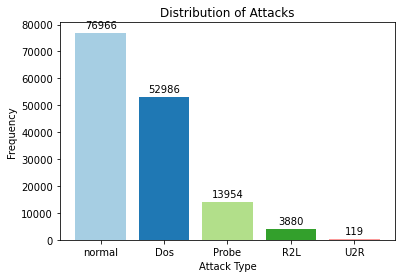

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Misalnya, df adalah DataFrame Anda dan 'attack' adalah kolom yang ingin Anda visualisasikan
unique_attacks = df['attack'].value_counts()

# Pilih warna untuk setiap bar
colors = plt.cm.Paired(np.arange(len(unique_attacks)))

# Plot bar chart
fig, ax = plt.subplots()
bars = ax.bar(unique_attacks.index, unique_attacks.values, color=colors)

# Tambahkan label pada setiap bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars)

# Tambahkan judul dan label pada sumbu
plt.title('Distribution of Attacks')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')

# Tampilkan grafik
plt.show()


In [16]:
# Split the dataset into input features and target variable
X_CWXGB = df.drop(['attack'], axis=1)
y_CWXGB = df['attack']

X_train_CWXGB, X_test_CWXGB, y_train_CWXGB, y_test_CWXGB = train_test_split(X_CWXGB, y_CWXGB, test_size = 0.3, random_state = 0)
# instantiate the label encoder
le = LabelEncoder()

# fit and transform the target data using the label encoder
y_train_CWXGB_encoded = le.fit_transform(y_train_CWXGB)

In [17]:
def imbalance_ratio(y_CWXGB, class_label):
    n_samples = len(y_CWXGB)
    class_count = np.sum(y_CWXGB == class_label)
    
    ir = (n_samples - class_count) / n_samples
    return ir

def calculate_fir(y_CWXGB):
    unique_classes = np.unique(y_CWXGB)
    fir_values = []

    for class_label in unique_classes:
        ir = imbalance_ratio(y_CWXGB, class_label)
        fir_values.append(ir)

    return max(fir_values)
# Contoh penggunaan
imbalance = calculate_fir(y_CWXGB)
print(f"Label y: {y_CWXGB.values}")
print(f"Max FIR for all classes in y: {imbalance:.10f}")

Label y: ['normal' 'Dos' 'normal' ... 'normal' 'Dos' 'Probe']
Max FIR for all classes in y: 0.9991954295


In [18]:
# Menghitung frekuensi masing-masing kelas
#class_frequencies = np.bincount(y_train_CWXGB_encoded)

# Hitung total sampel di semua kelas
#total_samples = len(y_train_CWXGB_encoded)

# Hitung bobot kelas secara manual untuk setiap kelas
#class_weights = total_samples / (len(class_frequencies) * class_frequencies)

In [19]:
def xgboost_objective(max_delta_step,max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight):
    params = {
        'objective': 'multi:softmax',
        'num_class': 5,
        'tree_method': 'hist',
        'max_delta_step' : max_delta_step,
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'min_child_weight': min_child_weight
    }
    # transform the target data using the label encoder
    y_train_CWXGB_encoded = le.transform(y_train_CWXGB)
    dtrain = xgb.DMatrix(X_train_CWXGB, label=y_train_CWXGB_encoded)
    dval = xgb.DMatrix(X_test_CWXGB, label=le.transform(y_test_CWXGB))
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], early_stopping_rounds=10, verbose_eval=False)
    val_score = model.best_score
    return -val_score


In [20]:
# Define the search space for the hyperparameters
pbounds = {
#    'n_estimators': (50, 200),
    'max_delta_step' :(0, 10),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 1),
    'min_child_weight': (1, 10)
}

In [21]:
# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgboost_objective, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=40)

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.06463  | 0.6873    | 0.9507    | 0.3687    | 5.987     | 4.092     | 2.404     | 0.529     |
| 2         | -0.6841   | 0.9331    | 0.6011    | 0.357     | 0.2058    | 9.789     | 8.492     | 0.6062    |
| 3         | -0.2709   | 0.5909    | 0.1834    | 0.1591    | 5.248     | 6.024     | 3.621     | 0.8059    |
| 4         | -0.1882   | 0.5697    | 0.2921    | 0.1895    | 4.561     | 8.496     | 2.797     | 0.7571    |
| 5         | -0.1286   | 0.7962    | 0.04645   | 0.3077    | 1.705     | 3.455     | 9.54      | 0.9828    |
| 6         | -0.7727   | 0.9042    | 0.3046    | 0.05786   | 6.842     | 6.081     | 2.098     | 0.7476    |
| 7         | -0.3579   | 0.5172    | 0.9093    | 0.1368    | 6.625     | 5.182     | 5.681     | 0.7734    |
| 8       

| 45        | -0.01165  | 1.0       | 1.0       | 0.5       | 5.839     | 10.0      | 1.0       | 1.0       |
| 46        | -0.0541   | 1.0       | 1.0       | 0.5       | 8.88      | 3.0       | 3.539     | 0.5       |
| 47        | -0.01265  | 0.5       | 0.0       | 0.5       | 7.834     | 10.0      | 1.0       | 0.5       |
| 48        | -0.3664   | 0.954     | 0.8907    | 0.1449    | 9.902     | 3.091     | 1.024     | 0.5348    |
| 49        | -1.41     | 1.0       | 0.0       | 0.01      | 0.0       | 3.0       | 5.594     | 1.0       |
| 50        | -1.395    | 0.5794    | 0.9121    | 0.2565    | 0.05836   | 3.022     | 9.9       | 0.7241    |


In [22]:
# Print the best score and parameters
print(optimizer.max)

{'target': -0.01137010221433833, 'params': {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.5, 'max_delta_step': 3.378818843016633, 'max_depth': 9.767951518247578, 'min_child_weight': 1.0, 'subsample': 1.0}}


In [23]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
start_time = time.time()

# instantiate the label encoder
le = LabelEncoder()

# fit and transform the target data using the label encoder
y_train_CWXGB_encoded = le.fit_transform(y_train_CWXGB)


# Train the XGBoost model using the best hyperparameters
best_xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 5,
    'scale_pos_weight' : imbalance,
    'tree_method' : 'hist',
#    'n_estimators': int(optimizer.max['params']['n_estimators']),
    'max_delta_step': int(optimizer.max['params']['max_delta_step']),
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'gamma': optimizer.max['params']['gamma'],
    'min_child_weight': optimizer.max['params']['min_child_weight']
}
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)
#best_model = xgb.train(best_xgb_params, dtrain, evals=[(dtest, 'validation', 'auc')], early_stopping_rounds=100, verbose_eval=True)
xgb_clf_CWXGB = xgb.XGBClassifier(**best_xgb_params, eval_metric=["mlogloss", "merror", "auc"], early_stopping_rounds=100)

eval_set_CWXGB = [(X_train_CWXGB, y_train_CWXGB_encoded), (X_test_CWXGB, le.transform(y_test_CWXGB))]
xgb_clf_CWXGB.fit(X_train_CWXGB, y_train_CWXGB_encoded, eval_set=eval_set_CWXGB, verbose=True)
XGB_time_CWXGB = (time.time() - start_time)
print("n_estimator 100: %f" % (XGB_time_CWXGB))
print()
print("elapsed time in seconds: ", XGB_time_CWXGB)

print()
gc.collect()

# make predictions on test data
predictions_XGB_CWXGB = le.inverse_transform(xgb_clf_CWXGB.predict(X_test_CWXGB))

print()
gc.collect()


[19:13:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-mlogloss:0.62343	validation_0-merror:0.00501	validation_0-auc:0.99988	validation_1-mlogloss:0.62565	validation_1-merror:0.00708	validation_1-auc:0.99981
[1]	validation_0-mlogloss:0.34815	validation_0-merror:0.00263	validation_0-auc:0.99997	validation_1-mlogloss:0.35084	validation_1-merror:0.00435	validation_1-auc:0.99992
[2]	validation_0-mlogloss:0.20466	validation_0-merror:0.00168	validation_0-auc:0.99999	validation_1-mlogloss:0.20785	validation_1-merror:0.00347	validation_1-auc:0.99991
[3]	validation_0-mlogloss:0.12335	validation_0-merror:0.00139	validation_0-auc:1.00000	validation_1-mlogloss:0.12652	validation_1-merror:0.00300	validation_1-auc:0.99998
[4]	validation_0-mlogloss:0.07565	validation_0-merror:0.00114	validation_0-auc:1.00000	validation_1-mlogloss:0.078

[47]	validation_0-mlogloss:0.00016	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00320	validation_1-merror:0.00088	validation_1-auc:1.00000
[48]	validation_0-mlogloss:0.00015	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00320	validation_1-merror:0.00088	validation_1-auc:1.00000
[49]	validation_0-mlogloss:0.00015	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00320	validation_1-merror:0.00088	validation_1-auc:1.00000
[50]	validation_0-mlogloss:0.00015	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00320	validation_1-merror:0.00088	validation_1-auc:1.00000
[51]	validation_0-mlogloss:0.00014	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00317	validation_1-merror:0.00088	validation_1-auc:1.00000
[52]	validation_0-mlogloss:0.00014	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00315	validation_1-merror:0.00088

[95]	validation_0-mlogloss:0.00009	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00306	validation_1-merror:0.00083	validation_1-auc:1.00000
[96]	validation_0-mlogloss:0.00009	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00305	validation_1-merror:0.00083	validation_1-auc:1.00000
[97]	validation_0-mlogloss:0.00009	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00305	validation_1-merror:0.00083	validation_1-auc:1.00000
[98]	validation_0-mlogloss:0.00009	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00305	validation_1-merror:0.00083	validation_1-auc:1.00000
[99]	validation_0-mlogloss:0.00009	validation_0-merror:0.00000	validation_0-auc:1.00000	validation_1-mlogloss:0.00305	validation_1-merror:0.00083	validation_1-auc:1.00000
n_estimator 100: 10.863333

elapsed time in seconds:  10.863332748413086




0

In [24]:
xgb_clf_CWXGB.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'eval_metric': ['mlogloss', 'merror', 'auc'],
 'gamma': 0.0,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 3,
 'max_depth': 9,
 'max_leaves': None,
 'min_child_weight': 1.0,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 0.9991954294986647,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'num_class': 5}

In [25]:
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score

print(classification_report(y_test_CWXGB, predictions_XGB_CWXGB))
# evaluate predictions
accuracy_XGB_CWXGB = accuracy_score(y_test_CWXGB, predictions_XGB_CWXGB)
print("Accuracy: %.10f%%" % (accuracy_XGB_CWXGB  * 100.0))
print('Accuracy score: {:.10f}'.format(accuracy_XGB_CWXGB))

              precision    recall  f1-score   support

         Dos       1.00      1.00      1.00     15770
       Probe       1.00      1.00      1.00      4133
         R2L       0.99      0.99      0.99      1140
         U2R       0.86      0.89      0.88        28
      normal       1.00      1.00      1.00     23301

    accuracy                           1.00     44372
   macro avg       0.97      0.98      0.97     44372
weighted avg       1.00      1.00      1.00     44372

Accuracy: 99.9166140810%
Accuracy score: 0.9991661408


In [26]:
precision_XGB_CWXGB = precision_score(y_test_CWXGB, predictions_XGB_CWXGB, average='macro')
recall_XGB_CWXGB = recall_score(y_test_CWXGB, predictions_XGB_CWXGB, average='macro')
f1_score_XGB_CWXGB = f1_score(y_test_CWXGB, predictions_XGB_CWXGB, average='macro')

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

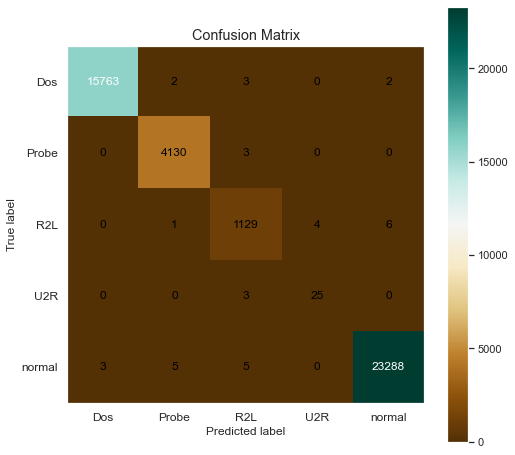

In [27]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(y_test_CWXGB, predictions_XGB_CWXGB, cmap="BrBG")

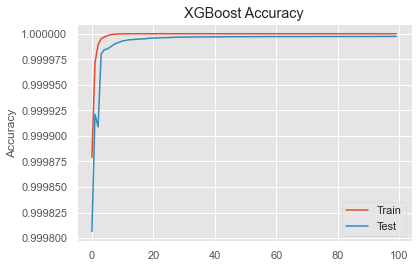

In [28]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# retrieve performance metrics
results_CWXGB = xgb_clf_CWXGB.evals_result()
epochs = len(results_CWXGB['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results_CWXGB['validation_0']['auc'], label='Train')
ax.plot(x_axis, results_CWXGB['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.show()

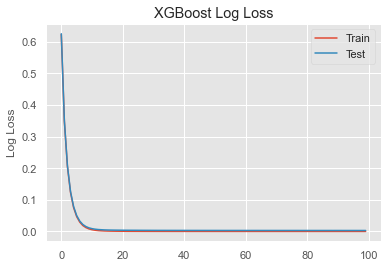

In [29]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results_CWXGB['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results_CWXGB['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

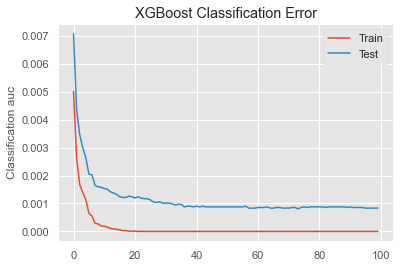

In [30]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results_CWXGB['validation_0']['merror'], label='Train')
ax.plot(x_axis, results_CWXGB['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification auc')
plt.title('XGBoost Classification Error')
plt.show()